In [8]:
from google.colab import files
uploaded = files.upload()


Saving faa_ai_prelim.csv to faa_ai_prelim.csv


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('faa_ai_prelim.csv')

# View initial information
print("Initial Shape:", df.shape)
print("Columns:\n", df.columns)
print(df.head())
print("\nMissing Values per Column:\n", df.isnull().sum())

Initial Shape: (83, 42)
Columns:
 Index(['UPDATED', 'ENTRY_DATE', 'EVENT_LCL_DATE', 'EVENT_LCL_TIME',
       'LOC_CITY_NAME', 'LOC_STATE_NAME', 'LOC_CNTRY_NAME', 'RMK_TEXT',
       'EVENT_TYPE_DESC', 'FSDO_DESC', 'REGIST_NBR', 'FLT_NBR', 'ACFT_OPRTR',
       'ACFT_MAKE_NAME', 'ACFT_MODEL_NAME', 'ACFT_MISSING_FLAG',
       'ACFT_DMG_DESC', 'FLT_ACTIVITY', 'FLT_PHASE', 'FAR_PART', 'MAX_INJ_LVL',
       'FATAL_FLAG', 'FLT_CRW_INJ_NONE', 'FLT_CRW_INJ_MINOR',
       'FLT_CRW_INJ_SERIOUS', 'FLT_CRW_INJ_FATAL', 'FLT_CRW_INJ_UNK',
       'CBN_CRW_INJ_NONE', 'CBN_CRW_INJ_MINOR', 'CBN_CRW_INJ_SERIOUS',
       'CBN_CRW_INJ_FATAL', 'CBN_CRW_INJ_UNK', 'PAX_INJ_NONE', 'PAX_INJ_MINOR',
       'PAX_INJ_SERIOUS', 'PAX_INJ_FATAL', 'PAX_INJ_UNK', 'GRND_INJ_NONE',
       'GRND_INJ_MINOR', 'GRND_INJ_SERIOUS', 'GRND_INJ_FATAL', 'GRND_INJ_UNK'],
      dtype='object')
  UPDATED ENTRY_DATE EVENT_LCL_DATE EVENT_LCL_TIME LOC_CITY_NAME  \
0      No  19-FEB-16      19-FEB-16      00:45:00Z    MARSHVILLE   
1      

In [10]:
# combine date and time
if 'EVENT_DATE' in df.columns and 'EVENT_TIME' in df.columns:
    df['EVENT_DATETIME'] = pd.to_datetime(
        df['EVENT_DATE'] + ' ' + df['EVENT_TIME'], errors='coerce'
    )
    print("New datetime column created:", df['EVENT_DATETIME'].head())


In [11]:
# select required columns
required_cols = [
    'ACFT_MAKE_NAME',   # Aircraft make
    'LOC_STATE_NAME',   # State
    'ACFT_MODEL_NAME',  # Aircraft model
    'RMK_TEXT',         # Text info
    'FLT_PHASE',        # Flight phase
    'ACFT_DMG_DESC',    # Event type
    'FATAL_FLAG'        # Fatal flag
]

df_req = df[required_cols].copy()
print("Selected Columns Shape:", df_req.shape)
print(df_req.head())


Selected Columns Shape: (83, 7)
  ACFT_MAKE_NAME  LOC_STATE_NAME ACFT_MODEL_NAME  \
0          BEECH  North Carolina              36   
1           VANS         Florida             RV7   
2         CESSNA      New Jersey             172   
3        LANCAIR  North Carolina             235   
4         CESSNA          Alaska             172   

                                            RMK_TEXT       FLT_PHASE  \
0  AIRCRAFT CRASHED INTO TREES, THE 1 PERSON ON B...   UNKNOWN (UNK)   
1  AIRCRAFT ON LANDING WENT OFF THE END OF THE RU...   LANDING (LDG)   
2  AIRCRAFT ON FINAL SUSTAINED A BIRD STRIKE, LAN...  APPROACH (APR)   
3  AIRCRAFT ON LANDING, GEAR COLLAPSED, ASHEVILLE...   LANDING (LDG)   
4  AIRCRAFT ON LANDING, NOSE GEAR COLLAPSED, TALK...   LANDING (LDG)   

  ACFT_DMG_DESC FATAL_FLAG  
0       Unknown        Yes  
1       Unknown        NaN  
2         Minor        NaN  
3       Unknown        NaN  
4         Minor        NaN  


In [12]:
# handling missing values

# replace fatal flag missing values with 'No'
df_req['FATAL_FLAG'] = df_req['FATAL_FLAG'].fillna('No')

# replace FLT_PHASE & ACFT_DMG_DESC missing with mode
for col in ['FLT_PHASE', 'ACFT_DMG_DESC']:
    mode_val = df_req[col].mode()[0]
    df_req[col] = df_req[col].fillna(mode_val)

print("Missing values after handling:\n", df_req.isnull().sum())


Missing values after handling:
 ACFT_MAKE_NAME     5
LOC_STATE_NAME     0
ACFT_MODEL_NAME    4
RMK_TEXT           0
FLT_PHASE          0
ACFT_DMG_DESC      0
FATAL_FLAG         0
dtype: int64


In [13]:
# drop unwanted data

# Drop rows where Aircraft Make is missing
before_rows = df_req.shape[0]
df_req = df_req.dropna(subset=['ACFT_MAKE_NAME'])
after_rows = df_req.shape[0]
print(f"Dropped {before_rows - after_rows} rows due to missing aircraft make.")

# Drop columns with >75% missing values
thresh = 0.25 * df_req.shape[0]  # At least 25% non-null
df_req = df_req.dropna(axis=1, thresh=thresh)

print("Shape after cleaning:", df_req.shape)
print("Remaining Columns:", df_req.columns.tolist())


Dropped 5 rows due to missing aircraft make.
Shape after cleaning: (78, 7)
Remaining Columns: ['ACFT_MAKE_NAME', 'LOC_STATE_NAME', 'ACFT_MODEL_NAME', 'RMK_TEXT', 'FLT_PHASE', 'ACFT_DMG_DESC', 'FATAL_FLAG']


In [14]:
# observation analysis

# Group by aircraft make
group_counts = df_req.groupby('ACFT_MAKE_NAME').size().reset_index(name='Count')
print("\nAircraft make occurrence counts:\n", group_counts)

# Display observations with Fatal Flag = Yes
fatal_cases = df_req[df_req['FATAL_FLAG'].str.upper() == 'YES']
print("\nFatal cases:\n", fatal_cases)



Aircraft make occurrence counts:
             ACFT_MAKE_NAME  Count
0           AERO COMMANDER      1
1                  AERONCA      1
2   AEROSTAR INTERNATIONAL      1
3                   AIRBUS      1
4                    BEECH      9
5                     BELL      2
6                   BOEING      3
7                   CESSNA     23
8                 CHAMPION      2
9                 CHRISTEN      1
10     CONSOLIDATED VULTEE      1
11                 EMBRAER      1
12                 ENSTROM      1
13               FAIRCHILD      1
14           FLIGHT DESIGN      1
15                   GLOBE      1
16             GREAT LAKES      1
17                 GRUMMAN      1
18              GULFSTREAM      1
19                  HUGHES      1
20                 LANCAIR      2
21                   MAULE      1
22                  MOONEY      4
23          NORTH AMERICAN      1
24                   PIPER     10
25                   PITTS      1
26                    SAAB      1
27           

In [15]:
# manual one-hot encoding

unique_dmg = df_req['ACFT_DMG_DESC'].unique()
for category in unique_dmg[:-1]:  # drop last to avoid multicollinearity
    df_req[f'DMG_{category}'] = (df_req['ACFT_DMG_DESC'] == category).astype(int)

print("DataFrame with One-Hot columns:\n", df_req.head())


DataFrame with One-Hot columns:
   ACFT_MAKE_NAME  LOC_STATE_NAME ACFT_MODEL_NAME  \
0          BEECH  North Carolina              36   
1           VANS         Florida             RV7   
2         CESSNA      New Jersey             172   
3        LANCAIR  North Carolina             235   
4         CESSNA          Alaska             172   

                                            RMK_TEXT       FLT_PHASE  \
0  AIRCRAFT CRASHED INTO TREES, THE 1 PERSON ON B...   UNKNOWN (UNK)   
1  AIRCRAFT ON LANDING WENT OFF THE END OF THE RU...   LANDING (LDG)   
2  AIRCRAFT ON FINAL SUSTAINED A BIRD STRIKE, LAN...  APPROACH (APR)   
3  AIRCRAFT ON LANDING, GEAR COLLAPSED, ASHEVILLE...   LANDING (LDG)   
4  AIRCRAFT ON LANDING, NOSE GEAR COLLAPSED, TALK...   LANDING (LDG)   

  ACFT_DMG_DESC FATAL_FLAG  DMG_Unknown  DMG_Minor  DMG_Substantial  
0       Unknown        Yes            1          0                0  
1       Unknown         No            1          0                0  
2         M

In [16]:
# feature engineering from text

keywords = ['LANDING', 'TAKEOFF', 'CRUISE', 'APPROACH']

def infer_flight_phase(text):
    if pd.isna(text):
        return 'UNKNOWN'
    text = text.upper()
    for kw in keywords:
        if kw in text:
            return kw
    return 'UNKNOWN'

df_req['FLIGHT_PHASE_TEXT'] = df_req['RMK_TEXT'].apply(infer_flight_phase)

# Compare inferred vs original flight phase
comparison = pd.crosstab(df_req['FLT_PHASE'], df_req['FLIGHT_PHASE_TEXT'])
print("\nComparison of FLT_PHASE vs Inferred from Text:\n", comparison)

print("\nFinal Preprocessed Dataset Shape:", df_req.shape)



Comparison of FLT_PHASE vs Inferred from Text:
 FLIGHT_PHASE_TEXT  APPROACH  LANDING  TAKEOFF  UNKNOWN
FLT_PHASE                                             
APPROACH (APR)            1        0        0        1
LANDING (LDG)             0       32        0       12
STANDING (STD)            0        0        0        3
TAKEOFF (TOF)             0        0        4        2
TAXI (TXI)                0        1        0        9
UNKNOWN (UNK)             0        0        0       13

Final Preprocessed Dataset Shape: (78, 11)


In [17]:
# saving final cleaned dataset
output_file = "Aviation_Preprocessed.csv"
df_req.to_csv(output_file, index=False)
print(f"Final preprocessed dataset saved as {output_file}")


Final preprocessed dataset saved as Aviation_Preprocessed.csv


/tmp/ipython-input-1905770389.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_aircraft.index, y=top_aircraft.values, palette='viridis', hue=None, legend=False)


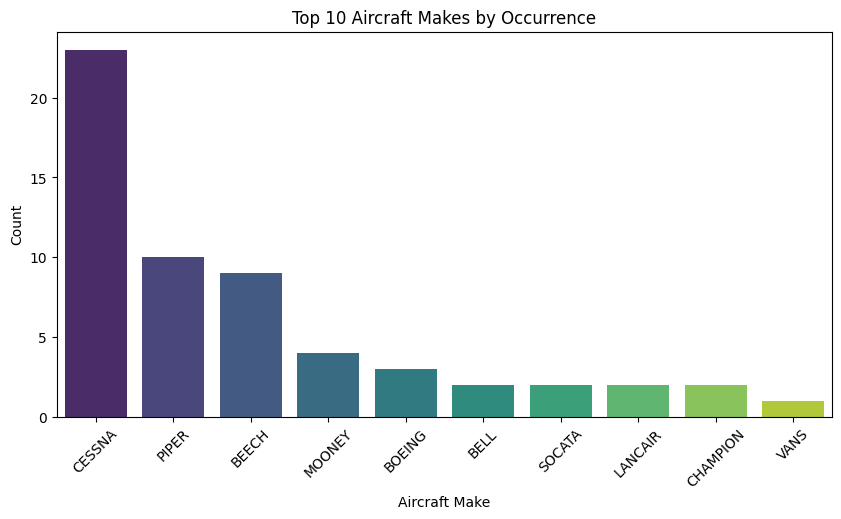

/tmp/ipython-input-1905770389.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fatal_counts.index, y=fatal_counts.values, palette='Reds', hue = None, legend= False)


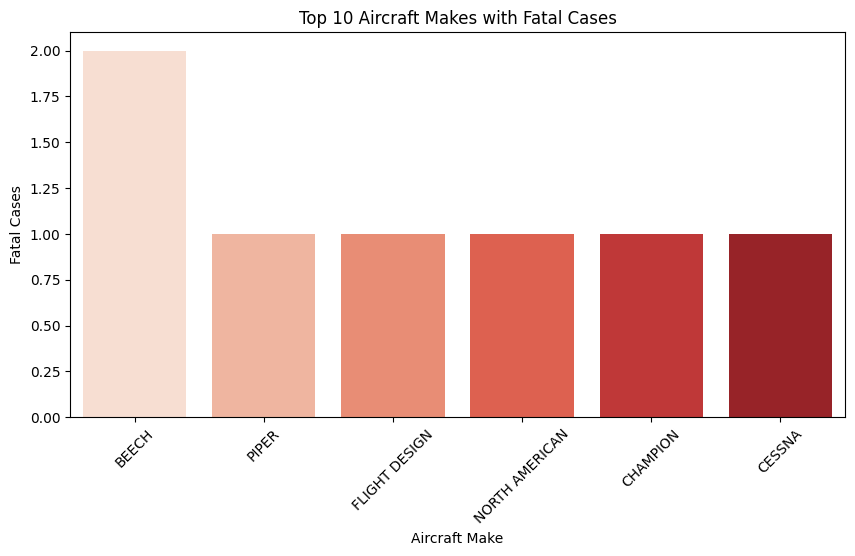

In [18]:
#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#1.Top 10 most frequent aircraft makes
plt.figure(figsize=(10,5))
top_aircraft = df_req['ACFT_MAKE_NAME'].value_counts().head(10)
sns.barplot(x=top_aircraft.index, y=top_aircraft.values, palette='viridis', hue=None, legend=False)
plt.xticks(rotation=45)
plt.title('Top 10 Aircraft Makes by Occurrence')
plt.xlabel('Aircraft Make')
plt.ylabel('Count')
plt.show()

#2.Fatal Cases per Aircraft Make (Top 10)
plt.figure(figsize=(10,5))
fatal_counts = df_req[df_req['FATAL_FLAG'].str.upper() == 'YES']['ACFT_MAKE_NAME'].value_counts().head(10)
sns.barplot(x=fatal_counts.index, y=fatal_counts.values, palette='Reds', hue = None, legend= False)
plt.xticks(rotation=45)
plt.title('Top 10 Aircraft Makes with Fatal Cases')
plt.xlabel('Aircraft Make')
plt.ylabel('Fatal Cases')
plt.show()
